In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['svg.fonttype'] = 'none'
import numpy as np
import matplotlib.dates as mdates
import xarray as xr

In [2]:
data_folder = "/home/cesardb/Documents/recherche/travail/ATLAS_SantanderMetGroup/data/ATLAS-main/datasets-aggregated-regionally/data"

plt_dict = {
    "historical":{"col":"#4a4e4d", "mrk":"v"},
    "rcp26":{"col":"#f6cd61", "mrk":"^"},
    "rcp45":{"col":"#fe8a71", "mrk":"^"},
    "rcp85":{"col":"#851e3e", "mrk":">"},
    "AIGUE":{"col":"#ee4035","mrk":"H"},
    "GUADA":{"col":"#f37736","mrk":"X"},
    "ORDES":{"col":"#ffe800","mrk":"o"},
    "PICOS":{"col":"#7bc043","mrk":"d"},
    "SIERR":{"col":"#0392cf","mrk":"s"},
    "DJF":{"col":"#0057e7","mrk":"*"},
    "MAM":{"col":"#008744","mrk":"s"},
    "JJA":{"col":"#d62d20","mrk":"."},
    "SON":{"col":"#ffa700","mrk":"^"},
    "MODIS":{"col":"#283655"},
    "SIMU": {"col":"#35a79c"}
    }

In [4]:
#########################################
#########################################
### MEDITERANNEA
#########################################
#########################################


region = "MED" # "world"
months_to_select = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ] #[12, 1, 2, 3, 4, 5]
n_month = len(months_to_select)
ref_date = "2005-09-01"
run_list = ["historical", "rcp26", "rcp45", "rcp85"]

In [5]:
# GET CMIP5 TEMPERATURE AND PRECIP DATA

# Find common gcm to all run

file_list = glob.glob( data_folder + "/CMIP5/CMIP5_tas_landsea/*" )
gcm_dict = {"historical":[], "rcp26":[], "rcp45":[], "rcp85":[]}
for file in file_list:
    gcm = ("_").join(file.split("/")[-1].split("_")[:-1])
    run = file.split("/")[-1].split("_")[-1].replace(".csv", "")
    gcm_dict[run].append(gcm)

gcm_common_list = list(set(gcm_dict["rcp26"]) & set(gcm_dict["rcp45"]) & set(gcm_dict["rcp85"]))

#############################
#############################
### CMIP5 TAS
#############################
#############################
     
tas_dict_all = {"historical":{}, "rcp26":{}, "rcp45":{}, "rcp85":{}}

for run in run_list:
    for gcm in gcm_common_list:
        in_file = glob.glob( data_folder + "/CMIP5/CMIP5_tas_landsea/*"+gcm+"*"+run+"*.csv" )[0]
        data = pd.read_csv(in_file, skiprows=15)[["date", region]]
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        data = data.to_xarray()
        data = data.sel({"date":data.date.dt.month.isin(months_to_select)})
        
        if run == "historical":
            data = data.sel(date=slice("1970-12-31","2005-12-01"))
        else:
            data = data.sel(date=slice("2005-12-31","2099-01-01"))

        tas_dict_all[run][gcm] = data
    
#############################
#############################
### CMIP5 PR
#############################
#############################

pr_dict_all =  {"historical":{}, "rcp26":{}, "rcp45":{}, "rcp85":{}}
for run in run_list:
    for gcm in gcm_common_list:
        in_file = glob.glob( data_folder + "/CMIP5/CMIP5_pr_landsea/*"+gcm+"*"+run+"*.csv" )[0]
        data = pd.read_csv(in_file, skiprows=15)[["date", region]]
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        data = data.to_xarray()
        data = data.sel({"date":data.date.dt.month.isin(months_to_select)})
        
        if run == "historical":
            data = data.sel(date=slice("1970-12-31","2005-12-01"))
        else:
            data = data.sel(date=slice("2005-12-31","2099-01-01"))
        pr_dict_all[run][gcm] = data
    
#############################
#############################
### OBS TAS
#############################
#############################
file = data_folder + "/OBSERVATIONS/OBS_tas_landsea/W5E5.csv"
data = pd.read_csv(file, skiprows=14)[["date", region]]
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
# Create a boolean mask to select the desired months
selected_months_mask = data.index.month.isin(months_to_select)

# Use the boolean mask to select the data for the desired months
tas_obs = data[selected_months_mask]    


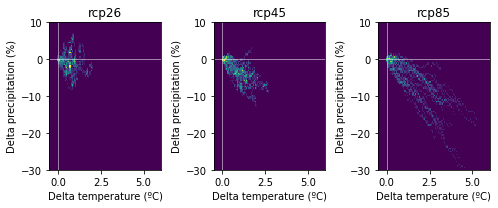

In [6]:
# PRECIP PLOT

# dPREC = f(dTEMP)

# ALL CMIP5
x_data, y_data = {"rcp26":[], "rcp45":[], "rcp85":[]}, {"rcp26":[], "rcp45":[], "rcp85":[]}
x_data_period, y_data_period = {"rcp26":[], "rcp45":[], "rcp85":[]}, {"rcp26":[], "rcp45":[], "rcp85":[]}

for gcm in gcm_common_list: #pr_dict.keys():
        for run in ["rcp26", "rcp45", "rcp85"]:
            pr_clim_concat = xr.merge([pr_dict_all["historical"][gcm], pr_dict_all[run][gcm]])
            pr_clim_mean = pr_clim_concat[region].rolling( date=30*n_month, center=True).mean()
            pr_ref = pr_clim_mean.loc[ref_date]

            tas_clim_concat = xr.merge([tas_dict_all["historical"][gcm], tas_dict_all[run][gcm]])
            tas_clim_mean = tas_clim_concat[region].rolling(date=30*n_month, center=True).mean()
            tas_ref = tas_clim_mean.loc[ref_date]
            x_data[run].append( (tas_clim_mean.sel(date=slice("2006-01", None))-tas_ref)[::12].to_numpy())
            y_data[run].append( (100*(pr_clim_mean.sel(date=slice("2006-01", None))-pr_ref)/pr_ref)[::12].to_numpy())

plt.figure(figsize=(7,3))
for ii , run in enumerate(["rcp26", "rcp45", "rcp85"]):
    plt.subplot(1, 3, ii+1)
    plt.hist2d(np.concatenate(x_data[run]), np.concatenate(y_data[run]), range=[[-0.5, 6],[-30, 10]], bins=100)
    plt.hlines(0,-0.5, 6, color="w", lw=0.5)
    plt.vlines(0,-30, 10, color="w", lw=0.5)
    plt.axis([-0.5, 6, -30, 10])
    plt.title(run)
    plt.xlabel("Delta temperature (ºC)")
    plt.ylabel("Delta precipitation (%)")

plt.tight_layout()
    #plt.hexbin(np.concatenate(x_data), np.concatenate(y_data), extent=[-1,10,-50,10], bins=100)



In [7]:
cmip5_ens_dict = { "all":[] }
for gcm in gcm_common_list: #pr_dict.keys():
        for run in ["rcp85"]:
            tas_clim_concat = xr.merge([tas_dict_all["historical"][gcm], tas_dict_all[run][gcm]])
            cmip5_ens_dict["all"].append( tas_clim_concat )
            


# RCP85 MEAN TEMP OF ENSEMBLE ALSO EXISTING IN RCP45 AND RCP26
tas_ens = xr.merge(cmip5_ens_dict["all"], compat='override')
da_concat = xr.concat(cmip5_ens_dict["all"], pd.Index(gcm_common_list, name='gcm'))
data_cmip5 = da_concat.mean(dim="gcm").to_pandas().rolling(30*n_month, center=True).mean()

# TO PLOT AGAINST MEAN TEMP FROM EACH SITE

In [8]:
anomaly_cmip5_common = {"rcp26":{}, "rcp45":{}, "rcp85":{}}
data4env = {"rcp26":[], "rcp45":[], "rcp85":[]}

for gcm in gcm_common_list:
    for run in ["rcp26", "rcp45", "rcp85"]:
        data_clim_mean = xr.merge([tas_dict_all["historical"][gcm], tas_dict_all[run][gcm]]).rolling(date = 30*n_month, center=True).mean()
      
        data_ref = data_clim_mean.sel(date=ref_date)
        anomaly_cmip5_common[run][gcm] = data_clim_mean.sel(date="2050-09-01") - data_ref
        data4env[run].append( data_clim_mean - data_ref )
        

/home/cesardb/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(0.0, 32872.0)
rcp26 0.7 0.84 0.99
rcp45 1.05 1.19 1.37
rcp85 1.54 1.76 2.08


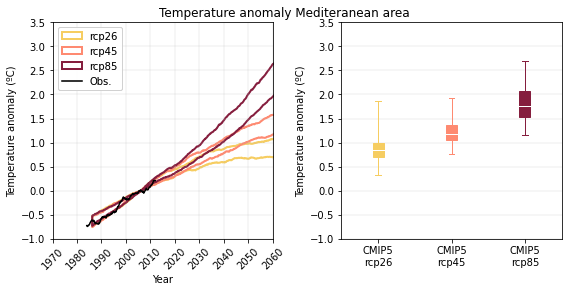

In [9]:

# CMIP5 AVAILABLE FROM SUBSET AVAILABLE in rcp26, rcp45, rcp85
plt.figure(figsize=(8,4))

        
plt.subplot(121)
for run in ["rcp26", "rcp45", "rcp85"]:
    a = xr.concat(data4env[run], dim="gcm")
#    plt.fill_between(a.date, a.min(dim={"gcm"}), a.max(dim={"gcm"}), color= plt_dict[run]["col"], alpha=0.4, label=run)
#     plt.fill_between(a.date, a.min(dim={"gcm"})[region],
#                      a.max(dim={"gcm"})[region],
#                      facecolor=[0,0,0,0],
#                      edgecolor = plt_dict[run]["col"],
#                      label=run,
#                      lw=2
#                     )
    
    plt.fill_between(a.date, 
                     a.quantile(0.25, dim={"gcm"})[region],
                     a.quantile(0.75, dim={"gcm"})[region],
                     facecolor=[0,0,0,0],
                     edgecolor = plt_dict[run]["col"],
                     label=run,
                     lw=2
                    )
    
tt = tas_obs.rolling(n_month*10, center=True).mean()
tas_obs_anomaly = tt - tt.loc[ref_date]
plt.plot(tas_obs_anomaly, "k", label="Obs.")

# Create a YearLocator to specify the tick locations every 10 years
year_locator = mdates.YearLocator(base=10)

# Create a DateFormatter to format the tick labels as years
year_format = mdates.DateFormatter('%Y')

# Set the x-axis locator and formatter
plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_format)
plt.xticks(rotation=45)
plt.grid(True,lw=0.2)
plt.xlim(pd.to_datetime('1970-01-01'), pd.to_datetime('2060-01-01'))
plt.ylim([-1, 3.5])
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (ºC)')
print(plt.gca().get_xlim())


# Get the current legend
legend = plt.legend()

# Create a dictionary to store unique labels and their corresponding handles
unique_labels = {}

# Iterate through legend entries and collect unique labels and handles
for handle, label in zip(legend.legendHandles, legend.get_texts()):
    if label.get_text() not in unique_labels:
        unique_labels[label.get_text()] = handle

# Create a new legend with unique labels and handles
new_legend = plt.legend(handles=list(unique_labels.values()), labels=list(unique_labels.keys()), loc="upper left")

# Add the new legend to the plot
plt.gca().add_artist(new_legend)



plt.subplot(122)
#plt.boxplot([ anomaly_cordex_ens[ff] for ff in anomaly_cordex_ens.keys()], showfliers=False, positions=[0])

for ii, run in enumerate(["rcp26", "rcp45", "rcp85"]):
    
    data2plot = [ anomaly_cmip5_common[run][ff][region].values.flatten()[0] for ff in anomaly_cmip5_common[run].keys()]
    print(run, np.round(np.percentile(data2plot,25),2),np.round(np.median(data2plot),2),np.round(np.percentile(data2plot,75),2))
    plt.boxplot(data2plot, 
                showfliers=False, 
                positions=[ii],
                patch_artist=True, 
                whis=1e9,
                boxprops = { "facecolor":plt_dict[run]["col"], "color":plt_dict[run]["col"]},
                capprops = { "color":plt_dict[run]["col"]},
                whiskerprops = { "color":plt_dict[run]["col"]},
                medianprops = { "color":"w"}
                )

plt.ylim([-1, 3.5])
plt.xticks([0,1,2], ["CMIP5\nrcp26", "CMIP5\nrcp45", "CMIP5\nrcp85"])
plt.grid(True,lw=0.2,axis="y")
plt.ylabel('Temperature anomaly (ºC)')
plt.tight_layout()

plt.suptitle("Temperature anomaly Mediteranean area", ha='center', va='center')
plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050.png")
plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050.svg")


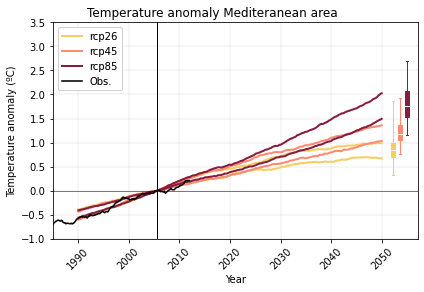

In [10]:

# CMIP5 AVAILABLE FROM SUBSET AVAILABLE in rcp26, rcp45, rcp85
plt.figure(figsize=(6,4))

#plt.subplot(121)
for run in ["rcp26", "rcp45", "rcp85"]:
    a = xr.concat(data4env[run], dim="gcm")
    a = a.where( (a.date > pd.to_datetime('1990-01-01')) & (a.date < pd.to_datetime('2050-01-01')), drop = True)
    plt.plot(a.date, a.quantile(0.25, dim={"gcm"})[region], color = plt_dict[run]["col"], label=run, lw=2)
    plt.plot(a.date, a.quantile(0.75, dim={"gcm"})[region], color = plt_dict[run]["col"], lw=2)
    
tt = tas_obs.rolling(n_month*10, center=True).mean()
tas_obs_anomaly = tt - tt.loc[ref_date]
plt.plot(tas_obs_anomaly, "k", label="Obs.")

# Create a YearLocator to specify the tick locations every 10 years
year_locator = mdates.YearLocator(base=10)

# Create a DateFormatter to format the tick labels as years
year_format = mdates.DateFormatter('%Y')




# Get the current legend
legend = plt.legend()

# Create a dictionary to store unique labels and their corresponding handles
unique_labels = {}

# Iterate through legend entries and collect unique labels and handles
for handle, label in zip(legend.legendHandles, legend.get_texts()):
    if label.get_text() not in unique_labels:
        unique_labels[label.get_text()] = handle

# Create a new legend with unique labels and handles
new_legend = plt.legend(handles=list(unique_labels.values()), labels=list(unique_labels.keys()), loc="upper left")

# Add the new legend to the plot
plt.gca().add_artist(new_legend)


#plt.subplot(122)
#plt.boxplot([ anomaly_cordex_ens[ff] for ff in anomaly_cordex_ens.keys()], showfliers=False, positions=[0])

for ii, run in enumerate(["rcp26", "rcp45", "rcp85"]):
    plt.boxplot([ anomaly_cmip5_common[run][ff][region].values.flatten()[0] for ff in anomaly_cmip5_common[run].keys()], 
                showfliers = False, 
                widths= 250,
                positions = [30000 + ii*500],
                patch_artist=True, 
                whis = 1e9,
                boxprops = { "facecolor":plt_dict[run]["col"], "color":plt_dict[run]["col"]},
                capprops = { "color":plt_dict[run]["col"]},
                whiskerprops = { "color":plt_dict[run]["col"]},
                medianprops = { "color":"w"}
                )



# Set the x-axis locator and formatter
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (ºC)')

plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_format)
plt.xticks(rotation=45)
plt.grid(True,lw=0.2)
plt.vlines(pd.to_datetime('2005-09-01'), -10, 10, color="k", lw=1)
plt.hlines(0, 0, 10000000, color="k", lw=0.5)
plt.xlim(pd.to_datetime('1985-01-01'), pd.to_datetime('2057-01-01'))
plt.ylim([-1, 3.5])
plt.grid(True,lw=0.2,axis="y")
plt.tight_layout()

plt.suptitle("Temperature anomaly Mediteranean area", ha='center', va='center')
plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050_all.png")
plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050_all.svg")


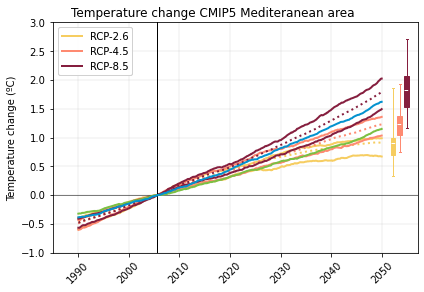

In [33]:

# CMIP5 AVAILABLE FROM SUBSET AVAILABLE in rcp26, rcp45, rcp85
plt.figure(figsize=(6,4))

#plt.subplot(121)
for run in ["rcp26", "rcp45", "rcp85"]:
    a = xr.concat(data4env[run], dim="gcm")
    a = a.where( (a.date > pd.to_datetime('1990-01-01')) & (a.date < pd.to_datetime('2050-01-01')), drop = True)
    plt.plot(a.date, a.quantile(0.25, dim={"gcm"})[region], color = plt_dict[run]["col"], label=run[:3].upper()+"-"+run[-2]+"."+run[-1], lw=2)
    plt.plot(a.date, a.mean(dim={"gcm"})[region], color = plt_dict[run]["col"], ls=":",lw=2)
    plt.plot(a.date, a.quantile(0.75, dim={"gcm"})[region], color = plt_dict[run]["col"], lw=2)
    
#tt = tas_obs.rolling(n_month*10, center=True).mean()
#tas_obs_anomaly = tt - tt.loc[ref_date]
#plt.plot(tas_obs_anomaly, "k", label="Obs.")

# Create a YearLocator to specify the tick locations every 10 years
year_locator = mdates.YearLocator(base=10)

# Create a DateFormatter to format the tick labels as years
year_format = mdates.DateFormatter('%Y')




# Get the current legend
legend = plt.legend()

# Create a dictionary to store unique labels and their corresponding handles
unique_labels = {}

# Iterate through legend entries and collect unique labels and handles
for handle, label in zip(legend.legendHandles, legend.get_texts()):
    if label.get_text() not in unique_labels:
        unique_labels[label.get_text()] = handle

# Create a new legend with unique labels and handles
new_legend = plt.legend(handles=list(unique_labels.values()), labels=list(unique_labels.keys()), loc="upper left")

# Add the new legend to the plot
plt.gca().add_artist(new_legend)


#plt.subplot(122)
#plt.boxplot([ anomaly_cordex_ens[ff] for ff in anomaly_cordex_ens.keys()], showfliers=False, positions=[0])
dT_rcp_2050 = {}

for ii, run in enumerate(["rcp26", "rcp45", "rcp85"]):
    data2plot = [ anomaly_cmip5_common[run][ff][region].values.flatten()[0] for ff in anomaly_cmip5_common[run].keys()]
    p = plt.boxplot( data2plot,
                showfliers = False, 
                widths= 350,
                positions = [30000 + ii*500],
                patch_artist=True, 
                whis = 1e9,
                boxprops = { "facecolor":plt_dict[run]["col"], "color":plt_dict[run]["col"]},
                capprops = { "color":plt_dict[run]["col"]},
                whiskerprops = { "color":plt_dict[run]["col"]},
                meanline=True,
                meanprops = { "color":"w"},
                showmeans=True,
                medianprops = { "color":"k","alpha":0},
                )
    dT_rcp_2050[run] = np.mean(data2plot)



# Set the x-axis locator and formatter
plt.ylabel('Temperature change (ºC)')

plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_format)
plt.xticks(rotation=45)
plt.grid(True,lw=0.2)
plt.vlines(pd.to_datetime('2005-09-01'), -10, 10, color="k", lw=1)
plt.hlines(0, 0, 10000000, color="k", lw=0.5)
plt.xlim(pd.to_datetime('1985-01-01'), pd.to_datetime('2057-01-01'))
plt.ylim([-1, 3])
plt.grid(True,lw=0.2,axis="y")
plt.tight_layout()
    
plt.suptitle("Temperature change CMIP5 Mediteranean area",va='center')
plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050_CORDEX_all.png")
plt.savefig("/media/cesardb/Datos/ATLAS_SantanderMetGroup/fig/CMIP5_2050_CORDEX_all.svg")


'RCP-8.5'

In [34]:
def get_closest(month_ref, date):
    # gets the 1st of month ref closest to date

    year = date.astype('datetime64[Y]').astype(int) + 1970
    month = int(date.astype('datetime64[M]').astype(str)[5:7])

    if month < month_ref:
        year -= 1

    # 1st of September for the same year and the next year
    sep_1_same_year = np.datetime64(f'{year}-09-01')
    sep_1_next_year = np.datetime64(f'{year + 1}-09-01')

    # Calculate the differences
    diff_to_same_year = abs(sep_1_same_year - date)
    diff_to_next_year = abs(sep_1_next_year - date)

    # Choose the closest date
    closest_sep_1 = sep_1_same_year if diff_to_same_year <= diff_to_next_year else sep_1_next_year
    
    return(closest_sep_1)
hyear_equivalent_2050 = {}
mean_cmip5_rcp85 = xr.concat(data4env["rcp85"], dim="gcm")
    
for run in ["rcp26", "rcp45", "rcp85"]:
    date = mean_cmip5_rcp85.where( mean_cmip5_rcp85.mean(dim={"gcm"}) >= dT_rcp_2050[run], drop=True ).date[0].values
    print(date)
    hyear_equivalent_2050[run] = get_closest(9, date)
hyear_equivalent_2050 # new bingo

2031-02-01T00:00:00.000000000
2038-11-01T00:00:00.000000000
2050-09-01T00:00:00.000000000


{'rcp26': numpy.datetime64('2030-09-01'),
 'rcp45': numpy.datetime64('2038-09-01'),
 'rcp85': numpy.datetime64('2050-09-01')}

In [ ]:
hyear_equivalent_rcp_2050 = {'mean':{'rcp26': 2030, 'rcp45': 2038, 'rcp85': 2050}}


In [189]:
2030-15,2030+15

(2015, 2045)